Dans ce notebook, nous allons effectuer une classification supervisée (RN) en utilisant l'apprentissage fédéré sur la dataset MIMIC-III, plus précisemment prédire la mortalité d'un patient.

Les importations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1.  Préparation des données



## Connexion à Google Drive
Cette cellule monte Google Drive pour accéder aux fichiers de la base de données MIMIC-III stockés sur le Drive.

In [ ]:
!pip install gdown
!gdown --fuzzy "https://drive.google.com/file/d/12QEebkIqEIIbWA8H1-Pu8IyDGVu88i98/view?usp=drive_link" -O MIMIC-III_dataset.zip
!unzip MIMIC-III_dataset.zip -d /content/

Downloading...
From: https://drive.google.com/uc?id=12QEebkIqEIIbWA8H1-Pu8IyDGVu88i98
To: /content/MIMIC-III_dataset.zip
100% 10.7M/10.7M [00:00<00:00, 38.2MB/s]
Archive:  MIMIC-III_dataset.zip
   creating: /content/MIMIC-III/
  inflating: /content/MIMIC-III/ADMISSIONS.csv  
  inflating: /content/MIMIC-III/CALLOUT.csv  
  inflating: /content/MIMIC-III/CAREGIVERS.csv  
  inflating: /content/MIMIC-III/CHARTEVENTS.csv  
  inflating: /content/MIMIC-III/CPTEVENTS.csv  
  inflating: /content/MIMIC-III/DATETIMEEVENTS.csv  
  inflating: /content/MIMIC-III/DIAGNOSES_ICD.csv  
  inflating: /content/MIMIC-III/DRGCODES.csv  
  inflating: /content/MIMIC-III/D_CPT.csv  
  inflating: /content/MIMIC-III/D_ICD_DIAGNOSES.csv  
  inflating: /content/MIMIC-III/D_ICD_PROCEDURES.csv  
  inflating: /content/MIMIC-III/D_ITEMS.csv  
  inflating: /content/MIMIC-III/D_LABITEMS.csv  
  inflating: /content/MIMIC-III/ICUSTAYS.csv  
  inflating: /content/MIMIC-III/INPUTEVENTS_CV.csv  
  inflating: /content/MIMIC-III

## Affichage des fichiers MIMIC-III
On commence par importer notre dataset, par lister tous les fichiers CSV disponibles dans le répertoire MIMIC-III pour vérifier les données disponibles.

In [ ]:
!ls "/content/MIMIC-III"

ADMISSIONS.csv	    DIAGNOSES_ICD.csv	  INPUTEVENTS_CV.csv	  PATIENTS.csv
CALLOUT.csv	    D_ICD_DIAGNOSES.csv   INPUTEVENTS_MV.csv	  PRESCRIPTIONS.csv
CAREGIVERS.csv	    D_ICD_PROCEDURES.csv  LABEVENTS.csv		  PROCEDUREEVENTS_MV.csv
CHARTEVENTS.csv     D_ITEMS.csv		  LICENSE.txt		  PROCEDURES_ICD.csv
CPTEVENTS.csv	    D_LABITEMS.csv	  MICROBIOLOGYEVENTS.csv  SERVICES.csv
DATETIMEEVENTS.csv  DRGCODES.csv	  NOTEEVENTS.csv	  SHA256SUMS.txt
D_CPT.csv	    ICUSTAYS.csv	  OUTPUTEVENTS.csv	  TRANSFERS.csv


In [ ]:
chartevents_file = "/content/MIMIC-III/CHARTEVENTS.csv"
labevents_file = "/content/MIMIC-III/LABEVENTS.csv"
outputevents_file = "/content/MIMIC-III/OUTPUTEVENTS.csv"
admissions_file = "/content/MIMIC-III/ADMISSIONS.csv"

usecols_chartevents = ["icustay_id", "charttime", "itemid", "valuenum"]
usecols_labevents = ["subject_id", "hadm_id", "charttime", "itemid", "valuenum"]
usecols_outputevents = ["subject_id", "hadm_id", "charttime", "itemid", "value"]


In [ ]:
df_chartevents = pd.read_csv("/content/MIMIC-III/CHARTEVENTS.csv", usecols=usecols_chartevents, low_memory=False)
df_labevents = pd.read_csv("/content/MIMIC-III/LABEVENTS.csv", usecols=usecols_labevents, low_memory=False)
df_outputevents = pd.read_csv(outputevents_file, usecols=usecols_outputevents, low_memory=False)
df_admissions = pd.read_csv(admissions_file, usecols=["subject_id", "admittime"])

## Extraction des caractéristiques cliniques
Dans cette partie, nous allons extraire tous les attributs que nous avons trouvé important afin de mieux entrainer nos modèles.

### 1. Extraction de l'échelle de Glasgow (GCS)
On extrait les composantes de l'échelle de Glasgow (verbale, motrice, oculaire) et calcule le score total, un indicateur neurologique important.

In [ ]:
gcs_items = {
    "GCSVerbal": [723, 223900],
    "GCSMotor": [454, 223901],
    "GCSEyes": [184, 220739]
}
df_gcs = df_chartevents[df_chartevents["itemid"].isin(sum(gcs_items.values(), []))]
df_gcs["Feature"] = df_gcs["itemid"].map({v: k for k, lst in gcs_items.items() for v in lst})
df_gcs = df_gcs.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_gcs["GCS_Total"] = df_gcs.sum(axis=1)
df_gcs.reset_index(inplace=True)


<ipython-input-5-05e92c8aa275>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gcs["Feature"] = df_gcs["itemid"].map({v: k for k, lst in gcs_items.items() for v in lst})


### 2. Extraction des signes vitaux
On extrait la pression artérielle systolique, la fréquence cardiaque et la température, avec conversion de Fahrenheit à Celsius.

In [ ]:
vital_signs = {
    "SysBP": [51, 442, 455, 220179, 220050],
    "HeartRate": [211, 220045],
    "Temperature_F": [678, 223761]
}
df_vitals = df_chartevents[df_chartevents["itemid"].isin(sum(vital_signs.values(), []))]
df_vitals["Feature"] = df_vitals["itemid"].map({v: k for k, lst in vital_signs.items() for v in lst})
df_vitals = df_vitals.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_vitals["Temperature_C"] = (df_vitals["Temperature_F"] - 32) * 5/9  # Convert F to C
df_vitals.drop(columns=["Temperature_F"], inplace=True)
df_vitals.reset_index(inplace=True)

<ipython-input-6-06c532115129>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vitals["Feature"] = df_vitals["itemid"].map({v: k for k, lst in vital_signs.items() for v in lst})


### 3.  Calcul du ratio PaO₂/FiO₂
On extrait les mesures de PaO₂ et FiO₂, puis calcule leur ratio, un indicateur crucial de la fonction respiratoire.

In [ ]:
# Pour extraire PaO2
df_labevents = pd.read_csv("/content/MIMIC-III/LABEVENTS.csv", low_memory=False)

df_pao2 = df_labevents[df_labevents["itemid"] == 50821].copy()  # PaO2 itemid
df_pao2["Feature"] = "PaO2"
df_pao2 = df_pao2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_pao2.reset_index(inplace=True)

# Pour extraire FiO2
df_chartevents = pd.read_csv("/content/MIMIC-III/CHARTEVENTS.csv", low_memory=False)

fio2_items = [223835, 190]  # FiO2 itemids
df_fio2 = df_chartevents[df_chartevents["itemid"].isin(fio2_items)].copy()
df_fio2["Feature"] = "FiO2"
df_fio2 = df_fio2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_fio2.reset_index(inplace=True)

# On concatene nos deux résultats
df_pao2_fio2 = pd.merge(df_pao2, df_fio2, on=["subject_id", "hadm_id", "charttime"], how="outer")

df_pao2_fio2["PaO2_FiO2_Ratio"] = df_pao2_fio2["PaO2"] / df_pao2_fio2["FiO2"]

# Remplacer les valeurs manquantes de PaO2_FiO2_Ratio par PaO2
df_pao2_fio2["PaO2_FiO2_Ratio"].fillna(df_pao2_fio2["PaO2"], inplace=True)

# Sauvegarder dans un fichier csv
df_pao2_fio2.to_csv("processed_pao2_fio2.csv", index=False)

print(df_pao2_fio2.head())
print("✅ Extraction and merging completed successfully!")


Feature  subject_id   hadm_id            charttime   PaO2  FiO2  \
0             10011  105331.0  2126-08-15 04:25:00  119.0   NaN   
1             10011  105331.0  2126-08-17 22:23:00  103.0   NaN   
2             10013  165520.0  2125-10-04 23:59:00   60.0   NaN   
3             10013  165520.0  2125-10-05 00:00:00    NaN   0.6   
4             10013  165520.0  2125-10-05 00:44:00  115.0   NaN   

Feature  PaO2_FiO2_Ratio  
0                  119.0  
1                  103.0  
2                   60.0  
3                    NaN  
4                  115.0  
✅ Extraction and merging completed successfully!


<ipython-input-7-9f867113ce88>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pao2_fio2["PaO2_FiO2_Ratio"].fillna(df_pao2_fio2["PaO2"], inplace=True)


### 4. Extraction de la production d'urine
On extrait et agrège les données de production d'urine par patient et période.

In [ ]:
# Urine itemids
urine_items = [40055, 43175, 40069, 40094, 40715, 40473, 40085, 40057, 40056]

#Extraire que les elements qui contiennent urine itemid
df_urine = df_outputevents[df_outputevents["itemid"].isin(urine_items)].copy()

# Vérifier si 'valuenum' existe, sinon utiliser 'value'
if "valuenum" in df_urine.columns:
    value_column = "valuenum"
elif "value" in df_urine.columns:
    value_column = "value"
else:
    raise KeyError("⚠ Aucune colonne valide de sortie urinaire trouvée dans OUTPUTEVENTS.csv!")

# Regrouper par subject_id, hadm_id et charttime
df_urine = df_urine.groupby(["subject_id", "hadm_id", "charttime"])[value_column].sum().reset_index()

# Renommer la colonne
df_urine.rename(columns={value_column: "UrineOutput"}, inplace=True)

print(df_urine.head())
print("✅ Extraction des données de sortie urinaire terminée avec succès!")

   subject_id  hadm_id            charttime  UrineOutput
0       10006   142345  2164-10-24 00:00:00        100.0
1       10006   142345  2164-10-25 03:00:00         10.0
2       10011   105331  2126-08-14 22:00:00        220.0
3       10011   105331  2126-08-14 23:00:00         50.0
4       10011   105331  2126-08-15 00:00:00         50.0
✅ Urine output extraction completed successfully!


### 5. Extraction des tests de laboratoire
On extrait diverses valeurs de laboratoire (globules blancs, bicarbonate, sodium, potassium, bilirubine, BUN).

In [ ]:
lab_items = {
    "WBC": [51300],
    "Bicarbonate": [50882],
    "Sodium": [950824, 50983],
    "Potassium": [50822, 50971],
    "Bilirubin": [50885],
    "BUN": [51006]
}

df_labs = df_labevents[df_labevents["itemid"].isin(sum(lab_items.values(), []))].copy()  # Utiliser .copy() pour éviter les avertissements

df_labs["Feature"] = df_labs["itemid"].map({v: k for k, lst in lab_items.items() for v in lst})

# Tableau croisé dynamique en utilisant subject_id et hadm_id au lieu de icustay_id
df_labs = df_labs.pivot_table(index=["subject_id", "hadm_id", "charttime"],
                              columns="Feature", values="valuenum", aggfunc="max")

# Réinitialiser l'index pour aplatir le DataFrame
df_labs.reset_index(inplace=True)

print(df_labs.head())
print("✅ Extraction des tests de laboratoire terminée avec succès !")

Feature  subject_id   hadm_id            charttime   BUN  Bicarbonate  \
0             10006  142345.0  2164-10-23 17:38:00   9.0         29.0   
1             10006  142345.0  2164-10-24 03:00:00  11.0         31.0   
2             10006  142345.0  2164-10-25 09:30:00  20.0         29.0   
3             10006  142345.0  2164-10-27 05:11:00  11.0         25.0   
4             10006  142345.0  2164-10-28 09:00:00  15.0         26.0   

Feature  Bilirubin  Potassium  Sodium  WBC  
0              1.0        6.0   139.0  NaN  
1              NaN        4.4   139.0  NaN  
2              NaN        4.6   138.0  NaN  
3              NaN        4.6   139.0  NaN  
4              NaN        5.1   141.0  NaN  
✅ Lab test extraction completed successfully!


## Fusion et préparation des données
### Fusion et prétraitement des données
On fusionne tous les dataframes extraits des différentes tables du dataset.

In [ ]:
dfs = [df_gcs, df_vitals, df_pao2_fio2, df_urine, df_labs]

# S'assurer que 'subject_id', 'hadm_id' et 'charttime' sont présents dans tous les DataFrames
for i, df in enumerate(dfs):
    # 1. Ajouter les colonnes manquantes
    for col in ["subject_id", "hadm_id", "charttime"]:
        if col not in df.columns:
            df[col] = pd.NA

    # 2. Convertir en types de données cohérents
    for col in ["subject_id", "hadm_id"]:
        if df[col].dtype != 'int64':  # Ajuster le type de données
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # 3. Gérer charttime - convertir en format datetime
    if df["charttime"].dtype != '<M8[ns]':
        df["charttime"] = pd.to_datetime(df["charttime"])

    dfs[i] = df

# Fusionner tous les DataFrames sur 'subject_id', 'hadm_id' et 'charttime' en une jointure externe
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = df_merged.merge(df, on=["subject_id", "hadm_id", "charttime"], how="outer")

print(df_merged.head())
print("✅ Fusion terminée avec succès !")

   icustay_id_x           charttime  GCSEyes  GCSMotor  GCSVerbal  GCS_Total  \
0           NaN 2164-10-23 17:38:00      NaN       NaN        NaN        NaN   
1           NaN 2164-10-24 00:00:00      NaN       NaN        NaN        NaN   
2           NaN 2164-10-24 03:00:00      NaN       NaN        NaN        NaN   
3           NaN 2164-10-25 03:00:00      NaN       NaN        NaN        NaN   
4           NaN 2164-10-25 09:30:00      NaN       NaN        NaN        NaN   

   subject_id  hadm_id  icustay_id_y  HeartRate  ...  PaO2  FiO2  \
0       10006   142345           NaN        NaN  ...   NaN   NaN   
1       10006   142345           NaN        NaN  ...   NaN   NaN   
2       10006   142345           NaN        NaN  ...   NaN   NaN   
3       10006   142345           NaN        NaN  ...   NaN   NaN   
4       10006   142345           NaN        NaN  ...   NaN   NaN   

   PaO2_FiO2_Ratio  UrineOutput   BUN  Bicarbonate  Bilirubin  Potassium  \
0              NaN          NaN   

On gère les valeurs manquantes selon plusieurs techniques et élimine les valeurs aberrantes.

In [ ]:
df_merged.sort_values(["subject_id", "hadm_id", "charttime"], inplace=True)

df_merged.fillna(method="ffill", inplace=True)
df_merged.fillna(method="bfill", inplace=True)
df_merged.fillna(df_merged.median(), inplace=True)

outlier_bounds = {
    "SysBP": (50, 250),
    "HeartRate": (30, 200),
    "Temperature_C": (30, 42),
    "PaO2_FiO2_Ratio": (50, 600),
    "UrineOutput": (0, 8000),
    "WBC": (2, 30),
    "Bicarbonate": (5, 45),
    "Sodium": (120, 160),
    "Potassium": (2, 7),
    "Bilirubin": (0.1, 50),
    "BUN": (2, 200),
    "GCS_Total": (3, 15)
}

for col, (low, high) in outlier_bounds.items():
    if col in df_merged.columns:
        df_merged[col] = np.clip(df_merged[col], low, high)

print(df_merged.head())
print("✅ Data sorting and cleaning completed successfully!")

   icustay_id_x           charttime  GCSEyes  GCSMotor  GCSVerbal  GCS_Total  \
0      254635.0 2164-10-23 17:38:00      3.0       4.0        4.0       11.0   
1      254635.0 2164-10-24 00:00:00      3.0       4.0        4.0       11.0   
2      254635.0 2164-10-24 03:00:00      3.0       4.0        4.0       11.0   
3      254635.0 2164-10-25 03:00:00      3.0       4.0        4.0       11.0   
4      254635.0 2164-10-25 09:30:00      3.0       4.0        4.0       11.0   

   subject_id  hadm_id  icustay_id_y  HeartRate  ...   PaO2  FiO2  \
0       10006   142345      254635.0       72.0  ...  119.0   0.6   
1       10006   142345      254635.0       72.0  ...  119.0   0.6   
2       10006   142345      254635.0       72.0  ...  119.0   0.6   
3       10006   142345      254635.0       72.0  ...  119.0   0.6   
4       10006   142345      254635.0       72.0  ...  119.0   0.6   

   PaO2_FiO2_Ratio  UrineOutput   BUN  Bicarbonate  Bilirubin  Potassium  \
0            119.0        10

<ipython-input-11-c91e4132e351>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method="ffill", inplace=True)
<ipython-input-11-c91e4132e351>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method="bfill", inplace=True)


## Exportation des données prétraitées

In [ ]:
df_merged.to_csv("processed_feature_set_A.csv", index=False)

print("Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.")

Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.


## Création des variables cibles de mortalité
On ajoute trois variables cibles: mortalité hospitalière, mortalité à 48h et mortalité à 30 jours.

In [ ]:
# Charger les données
df_final = pd.read_csv("processed_feature_set_A.csv")

# Charger ADMISSIONS.csv pour récupérer DEATHTIME et DISCHTIME
df_admissions = pd.read_csv("/content/MIMIC-III/ADMISSIONS.csv",
                            usecols=["subject_id", "hadm_id", "deathtime", "dischtime"])

# Charger ICUSTAYS.csv pour récupérer INTIME (entrée en soins intensifs)
df_icustays = pd.read_csv("/content/MIMIC-III/ICUSTAYS.csv",
                          usecols=["subject_id", "hadm_id", "intime"])

# Charger PATIENTS.csv pour récupérer DOD (Date of Death, date de décès)
df_patients = pd.read_csv("/content/MIMIC-III/PATIENTS.csv",
                          usecols=["subject_id", "dod"])

# Convertir les dates en format datetime
df_admissions["deathtime"] = pd.to_datetime(df_admissions["deathtime"])
df_admissions["dischtime"] = pd.to_datetime(df_admissions["dischtime"])
df_icustays["intime"] = pd.to_datetime(df_icustays["intime"])
df_patients["dod"] = pd.to_datetime(df_patients["dod"])

# Fusionner avec ADMISSIONS (Mortalité en hôpital)
df_final = df_final.merge(df_admissions, on=["subject_id", "hadm_id"], how="left")

# Fusionner avec PATIENTS (DOD)
df_final = df_final.merge(df_patients, on="subject_id", how="left")

# Fusionner avec ICUSTAYS (INTIME pour soins intensifs)
df_final = df_final.merge(df_icustays, on=["subject_id", "hadm_id"], how="left")

# Créer la colonne de mortalité en hôpital
df_final["Mortality"] = df_final["deathtime"].notnull().astype(int)

# Créer la mortalité à 48h après admission en soins intensifs
df_final["Mortality_48h"] = ((df_final["dod"] - df_final["intime"]).dt.total_seconds() / 3600 < 48).astype(int)

# Créer la mortalité à 30 jours après la sortie de l'hôpital
df_final["Mortality_30d"] = ((df_final["dod"] - df_final["dischtime"]).dt.days < 30).astype(int)

# Supprimer les colonnes inutiles
df_final.drop(columns=["deathtime", "dischtime", "dod", "intime"], inplace=True)

# Sauvegarder le dataset final
df_final.to_csv("final_dataset_with_mortality.csv", index=False)

# Vérifier la distribution des labels
print(df_final[["Mortality", "Mortality_48h", "Mortality_30d"]].sum())
print(df_final.head())
print("✅ Ajout des labels de mortalité terminé avec succès !")


Mortality        5777
Mortality_48h     275
Mortality_30d    6517
dtype: int64
   icustay_id_x            charttime  GCSEyes  GCSMotor  GCSVerbal  GCS_Total  \
0      254635.0  2164-10-23 17:38:00      3.0       4.0        4.0       11.0   
1      254635.0  2164-10-24 00:00:00      3.0       4.0        4.0       11.0   
2      254635.0  2164-10-24 03:00:00      3.0       4.0        4.0       11.0   
3      254635.0  2164-10-25 03:00:00      3.0       4.0        4.0       11.0   
4      254635.0  2164-10-25 09:30:00      3.0       4.0        4.0       11.0   

   subject_id  hadm_id  icustay_id_y  HeartRate  ...  UrineOutput   BUN  \
0       10006   142345      254635.0       72.0  ...        100.0   9.0   
1       10006   142345      254635.0       72.0  ...        100.0   9.0   
2       10006   142345      254635.0       72.0  ...        100.0  11.0   
3       10006   142345      254635.0       72.0  ...         10.0  11.0   
4       10006   142345      254635.0       72.0  ...       

#2. Préparation pour l'apprentissage fédéré


## Séparation et mélange des données
On divise les données entre survivants et décédés.

In [ ]:
mortality_0 = df_final[df_final['Mortality'] == 0]
mortality_1 = df_final[df_final['Mortality'] == 1]

On les mélange aléatoirement

In [ ]:
mortality_0 = mortality_0.sample(frac=1, random_state=42).reset_index(drop=True)
mortality_1 = mortality_1.sample(frac=1, random_state=42).reset_index(drop=True)

## Définition du nombre de clients
Nous avons opté pour 10 clients pour l'apprentissage fédéré.

In [ ]:
num_clients = 10

## Fonction de distribution non-IID
On crée une fonction pour distribuer les données de manière non identiquement distribuée entre les clients pour se rapprocher le plus possible du cas réel.

In [ ]:
def create_non_iid_distribution(data_0, data_1, num_clients, alpha=0.8):
    np.random.seed(None)  # Random seed for different results

    # Concatenate both classes together and shuffle
    data = pd.concat([data_0, data_1]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure each client gets at least 2 samples
    min_samples_per_client = 2
    total_samples = len(data)

    # Subtract minimum samples already assigned
    remaining_samples = total_samples - (num_clients * min_samples_per_client)

    # Generate proportions for remaining samples
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    counts = (proportions * remaining_samples).astype(int)

    # Ensure rounding errors do not cause a mismatch
    counts[-1] += remaining_samples - counts.sum()

    # Add back the minimum samples to each client
    counts += min_samples_per_client

    client_data = []
    start_idx = 0

    for i in range(num_clients):
        end_idx = start_idx + counts[i]
        client_df = data.iloc[start_idx:end_idx].sample(frac=1, random_state=i)  # Shuffle
        client_data.append(client_df.reset_index(drop=True))
        start_idx = end_idx

    return client_data

# Application de la distribution non-IID
Applique la distribution non-IID avec un paramètre alpha de 0.8.

In [ ]:
client_data = create_non_iid_distribution(mortality_0, mortality_1, num_clients, alpha=0.8)

# Visualisation de la distribution
On visualise et enregistre la distribution des classes entre les clients.

Distribution of classes across clients:
Client 1:
  Class 0 (Survived): 1218 samples (79.7%)
  Class 1 (Died): 311 samples (20.3%)
  Total: 1529 samples
------------------------------
Client 2:
  Class 0 (Survived): 24 samples (72.7%)
  Class 1 (Died): 9 samples (27.3%)
  Total: 33 samples
------------------------------
Client 3:
  Class 0 (Survived): 88 samples (80.7%)
  Class 1 (Died): 21 samples (19.3%)
  Total: 109 samples
------------------------------
Client 4:
  Class 0 (Survived): 2286 samples (80.0%)
  Class 1 (Died): 570 samples (20.0%)
  Total: 2856 samples
------------------------------
Client 5:
  Class 0 (Survived): 3453 samples (79.6%)
  Class 1 (Died): 885 samples (20.4%)
  Total: 4338 samples
------------------------------
Client 6:
  Class 0 (Survived): 42 samples (76.4%)
  Class 1 (Died): 13 samples (23.6%)
  Total: 55 samples
------------------------------
Client 7:
  Class 0 (Survived): 9379 samples (80.1%)
  Class 1 (Died): 2336 samples (19.9%)
  Total: 11715 samp

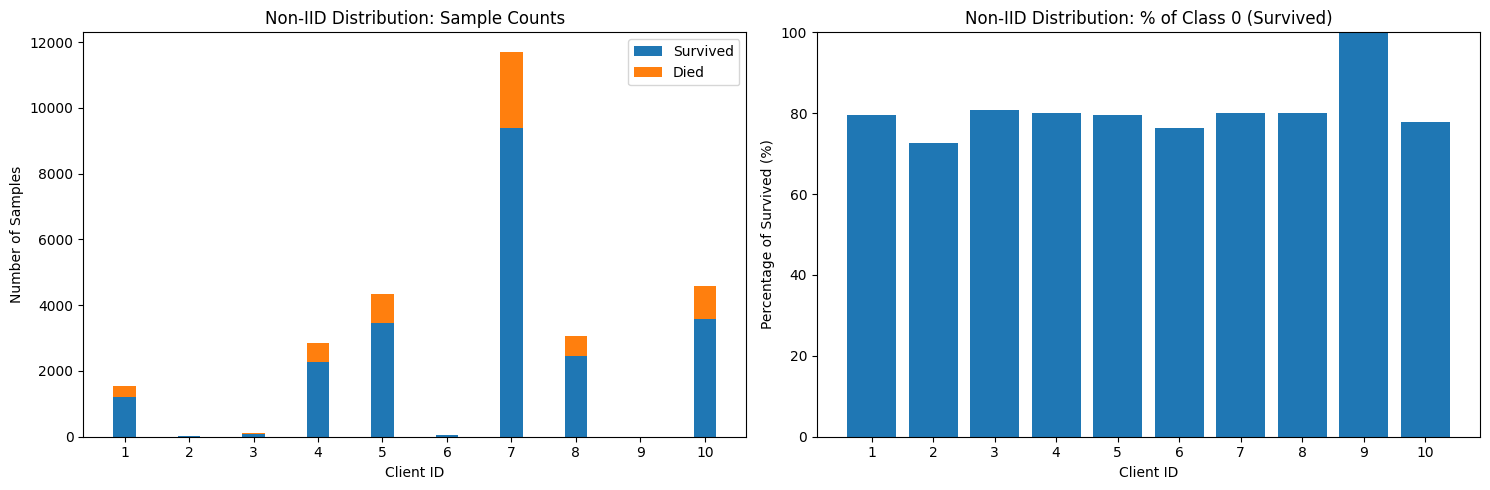

Non-IID data partitioning complete with 10 clients.


In [ ]:
def visualize_distribution(client_data):
    # Prepare data for plotting
    class_0_counts = []
    class_1_counts = []
    class_0_percent = []
    total_samples = []

    print("Distribution of classes across clients:")
    for i, client in enumerate(client_data):
        counts = client['Mortality'].value_counts().to_dict()
        count_0 = counts.get(0, 0)
        count_1 = counts.get(1, 0)
        total = len(client)

        class_0_counts.append(count_0)
        class_1_counts.append(count_1)
        class_0_percent.append(100 * count_0 / total)
        total_samples.append(total)

        print(f"Client {i+1}:")
        print(f"  Class 0 (Survived): {count_0} samples ({count_0/total:.1%})")
        print(f"  Class 1 (Died): {count_1} samples ({count_1/total:.1%})")
        print(f"  Total: {total} samples")
        print("-" * 30)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot raw counts
    x = np.arange(num_clients)
    width = 0.35
    ax1.bar(x, class_0_counts, width, label='Survived')
    ax1.bar(x, class_1_counts, width, bottom=class_0_counts, label='Died')
    ax1.set_xlabel('Client ID')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Non-IID Distribution: Sample Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax1.legend()

    # Plot percentage of class 0
    ax2.bar(x, class_0_percent)
    ax2.set_xlabel('Client ID')
    ax2.set_ylabel('Percentage of Survived (%)')
    ax2.set_title('Non-IID Distribution: % of Class 0 (Survived)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig('non_iid_distribution.png', dpi=300)
    plt.show()

# Visualize the non-IID distribution
visualize_distribution(client_data)

for i, client_df in enumerate(client_data):
    client_df.to_csv(f"client_{i+1}_data.csv", index=False)

print(f"Non-IID data partitioning complete with {num_clients} clients.")

#3. Implémentation de l'apprentissage fédéré
## Configuration PyTorch
On importe les différentes bibliothèques

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Définition du réseau de neurones
On crée une classe pour le réseau de neurones à deux couches avec régularisation par dropout.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        """
        Initialize the NeuralNetwork model.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output classes (1 for binary classification).
            dropout_prob (float): Dropout probability for regularization (default: 0.5).
        """
        super(NeuralNetwork, self).__init__()  # Initialize the parent class (nn.Module)

        # First fully connected layer (input to hidden layer)
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        # Initialize weights using Kaiming (He) initialization for ReLU activation
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")

        # Second fully connected layer (hidden layer to output layer)
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
        # Initialize weights using Xavier (Glorot) initialization for the output layer
        nn.init.xavier_uniform_(self.layer_2.weight)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.layer_1(x))

        # Apply dropout for regularization
        x = self.dropout(x)

        # Apply the second fully connected layer
        x = self.layer_2(x)

        return x

## Classe Client pour l'apprentissage fédéré
On définit une classe client avec des méthodes pour préparer les données, s'entraîner et évaluer le modèle.

In [ ]:
class FederatedClient:
    def __init__(self, client_id, train_data, test_data, input_dim, hidden_dim, output_dim, dropout_prob=0.5, lr=0.001):
        """
        Initialize a federated learning client.

        Args:
            client_id (str): Unique identifier for the client.
            train_data (tuple): Tuple of (features, labels) for training data.
            test_data (tuple): Tuple of (features, labels) for test data.
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output classes (1 for binary classification).
            dropout_prob (float): Dropout probability for regularization (default: 0.5).
            lr (float): Learning rate for the optimizer (default: 0.001).
        """
        self.client_id = client_id
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        self.lr = lr

        # Prepare training and test data
        self.train_loader = self._prepare_data(train_data)
        self.test_loader = self._prepare_data(test_data)

        # Initialize the local model
        self.model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob)
        self.criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def _prepare_data(self, data):
        """
        Convert raw data into a PyTorch DataLoader.

        Args:
            data (tuple): Tuple of (features, labels).

        Returns:
            DataLoader: PyTorch DataLoader for the given data.
        """
        features, labels = data
        dataset = TensorDataset(torch.tensor(features, dtype=torch.float32),
                               torch.tensor(labels, dtype=torch.float32).reshape(-1, 1))
        return DataLoader(dataset, batch_size=32, shuffle=True)

    def train(self, global_model_weights):
        """
        Train the local model using the client's data.

        Args:
            global_model_weights (dict): State dictionary of the global model weights.

        Returns:
            dict: Updated local model weights.
        """
        # Load the global model weights into the local model
        self.model.load_state_dict(global_model_weights)
        self.model.train()

        # Local training loop
        for epoch in range(10):  # Train for 10 epochs (can be adjusted)
            for batch_x, batch_y in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()

        # Return the updated model weights
        return self.model.state_dict()

    def evaluate(self):
        """
        Evaluate the local model on the client's test data.

        Returns:
            float: Accuracy of the model on the test data.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in self.test_loader:
                outputs = self.model(batch_x)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = 100 * correct / total
        return accuracy
    def evaluate_train(self):
      """
      Évalue le modèle local sur les données d'entraînement.
      Returns:
          float: Accuracy sur l'ensemble d'entraînement.
      """
      self.model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_x, batch_y in self.train_loader:
              outputs = self.model(batch_x)
              predicted = (torch.sigmoid(outputs) > 0.5).float()
              total += batch_y.size(0)
              correct += (predicted == batch_y).sum().item()
      return 100 * correct / total
    def calculate_loss(self, data_loader):
      """
      Calcule la perte moyenne du modèle sur un DataLoader donné.

      Args:
          data_loader (DataLoader): DataLoader contenant les données à évaluer.

      Returns:
          float: Perte moyenne.
      """
      self.model.eval()
      total_loss = 0.0
      total_samples = 0

      with torch.no_grad():
          for batch_x, batch_y in data_loader:
              outputs = self.model(batch_x)
              loss = self.criterion(outputs, batch_y)
              total_loss += loss.item() * batch_y.size(0)
              total_samples += batch_y.size(0)

      return total_loss / total_samples



## Classe Serveur pour l'apprentissage fédéré
On définit la classe serveur qui agrège les poids des modèles et orchestre le processus d'apprentissage.

In [ ]:
class FederatedServer:
    def __init__(self, global_model, clients):
        """
        Initialize the federated learning server.

        Args:
            global_model (nn.Module): The global model to be trained.
            clients (list): List of FederatedClient instances.
        """
        self.global_model = global_model
        self.clients = clients

    def aggregate_weights(self, client_weights):
        """
        Aggregate client model weights using Federated Averaging.

        Args:
            client_weights (list): List of state dictionaries from clients.

        Returns:
            dict: Aggregated global model weights.
        """
        global_weights = self.global_model.state_dict()

        # Average the weights
        for key in global_weights:
            global_weights[key] = torch.stack([client_weights[i][key] for i in range(len(client_weights))]).mean(0)

        return global_weights

    def run_federated_learning(self, num_rounds):
        """
        Run the federated learning process for a specified number of rounds.

        Args:
            num_rounds (int): Number of federated learning rounds.
        """
        for round in range(num_rounds):
            print(f"Round {round + 1}/{num_rounds}")

            # List to store updated weights from clients
            client_weights = []

            # Train each client and collect updated weights
            for client in self.clients:
                print(f"Training {client.client_id}...")
                updated_weights = client.train(self.global_model.state_dict())
                client_weights.append(updated_weights)

                # Evaluate the client's model
                accuracy = client.evaluate()
                print(f"{client.client_id} Test Accuracy: {accuracy:.2f}%")

            # Aggregate client weights to update the global model
            global_weights = self.aggregate_weights(client_weights)
            self.global_model.load_state_dict(global_weights)

            # Evaluate the global model on all clients' test data
            global_accuracy = self.evaluate_global_model()
            print(f"Global Model Test Accuracy: {global_accuracy:.2f}%")

    def evaluate_global_model(self):
        """
        Evaluate the global model on all clients' test data.

        Returns:
            float: Average accuracy of the global model across all clients.
        """
        self.global_model.eval()
        total_accuracy = 0

        for client in self.clients:
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_x, batch_y in client.test_loader:
                    outputs = self.global_model(batch_x)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()

            accuracy = 100 * correct / total
            total_accuracy += accuracy

        return total_accuracy / len(self.clients)

# Suivi des Métriques et Early Stopping
Cette fonction orchestre le processus d'apprentissage fédéré en collectant les métriques de performance (accuracy, loss) sur les ensembles d'entraînement et de test à chaque round. Elle implémente également un mécanisme d'arrêt précoce (early stopping) qui interrompt l'apprentissage lorsque les performances n'augmentent plus suffisamment

In [ ]:
def run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3, min_improvement=0.001):
    """
    Exécute l'apprentissage fédéré en collectant les métriques train/test et avec early stopping.
    """
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    history = []
    best_accuracy = 0
    rounds_without_improvement = 0

    for round_num in range(max_rounds):
        print(f"Round {round_num + 1}/{max_rounds}")

        # Liste pour stocker les poids clients
        client_weights = []

        # Entraîner chaque client et collecter les métriques
        round_train_accuracies = []
        round_test_accuracies = []
        round_train_losses = []
        round_test_losses = []

        for client in federated_server.clients:
            updated_weights = client.train(federated_server.global_model.state_dict())
            client_weights.append(updated_weights)

            # Évaluer sur train et test
            train_acc = client.evaluate_train()
            test_acc = client.evaluate()

            # Calculer les losses
            train_loss = client.calculate_loss(client.train_loader)
            test_loss = client.calculate_loss(client.test_loader)

            round_train_accuracies.append(train_acc)
            round_test_accuracies.append(test_acc)
            round_train_losses.append(train_loss)
            round_test_losses.append(test_loss)

        # Agréger les poids comme avant
        global_weights = federated_server.aggregate_weights(client_weights)
        federated_server.global_model.load_state_dict(global_weights)

        # Calculer la moyenne des accuracies pour ce round
        avg_train_accuracy = sum(round_train_accuracies) / len(round_train_accuracies)
        avg_test_accuracy = sum(round_test_accuracies) / len(round_test_accuracies)

        # Calculer la moyenne des losses
        avg_train_loss = sum(round_train_losses) / len(round_train_losses)
        avg_test_loss = sum(round_test_losses) / len(round_test_losses)

        train_accuracies.append(avg_train_accuracy)
        test_accuracies.append(avg_test_accuracy)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Évaluer le modèle global pour l'early stopping
        global_accuracy = federated_server.evaluate_global_model()
        history.append(global_accuracy)

        # Vérification pour l'early stopping
        if global_accuracy > best_accuracy + min_improvement:
            best_accuracy = global_accuracy
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
            print(f"Pas d'amélioration significative. Rounds sans amélioration: {rounds_without_improvement}/{patience}")
            if rounds_without_improvement >= patience:
                print(f"Early stopping après {round_num + 1} rounds")
                break

    # Visualiser l'écart entre train et test pour accuracy
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title("Évolution des performances sur l'entraînement et le test")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualiser les courbes de loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.title("Évolution de la perte (Loss) durant l'apprentissage fédéré")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_accuracies, test_accuracies, train_losses, test_losses, history


# Initialisation et lancement de l'apprentissage fédéré
Etape finale de notre implémentation d'apprentissage fédéré. Elle comprend:

- La préparation des données pour chaque client (séparation des caractéristiques et des étiquettes)

- L'initialisation du modèle global avec les dimensions précédemment définies

- La création des instances de clients fédérés avec leurs données respectives

- L'initialisation du serveur fédéré qui orchestrera l'apprentissage

- Le lancement du processus d'apprentissage fédéré sur plusieurs rounds

Modèle global initialisé avec 17 caractéristiques d'entrée, 64 neurones cachés
Client_1 initialisé avec 1223 échantillons d'entraînement et 306 échantillons de test
Client_2 initialisé avec 26 échantillons d'entraînement et 7 échantillons de test
Client_3 initialisé avec 87 échantillons d'entraînement et 22 échantillons de test
Client_4 initialisé avec 2284 échantillons d'entraînement et 572 échantillons de test
Client_5 initialisé avec 3470 échantillons d'entraînement et 868 échantillons de test
Client_6 initialisé avec 44 échantillons d'entraînement et 11 échantillons de test
Client_7 initialisé avec 9372 échantillons d'entraînement et 2343 échantillons de test
Client_8 initialisé avec 2456 échantillons d'entraînement et 614 échantillons de test
Client_9 initialisé avec 1 échantillons d'entraînement et 1 échantillons de test
Client_10 initialisé avec 3676 échantillons d'entraînement et 920 échantillons de test
Serveur fédéré initialisé

Démarrage de l'apprentissage fédéré...
Round 1/

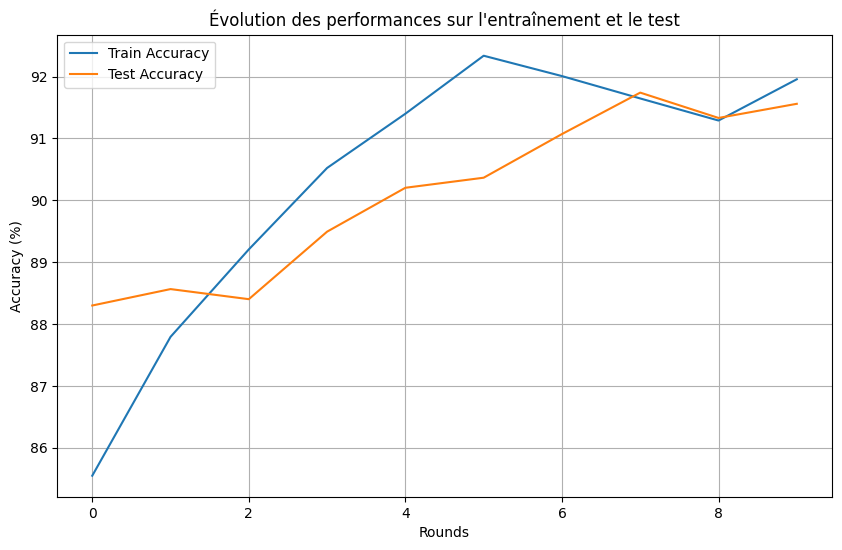

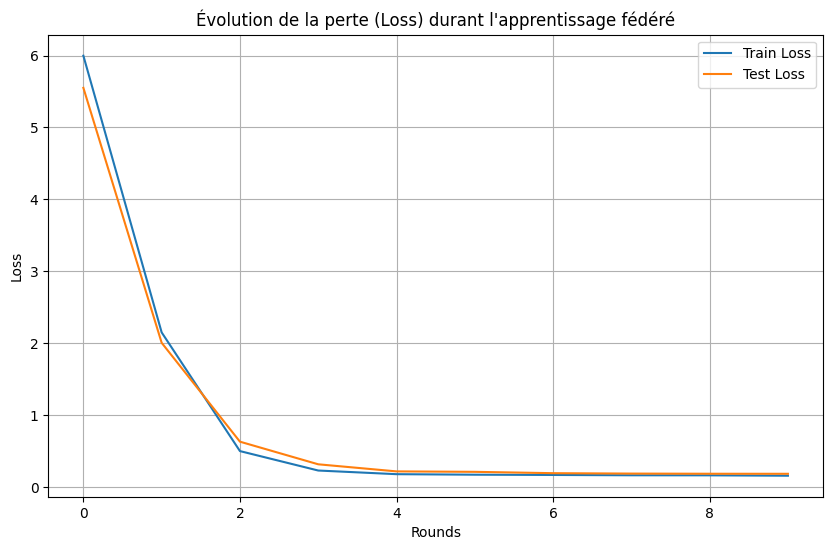

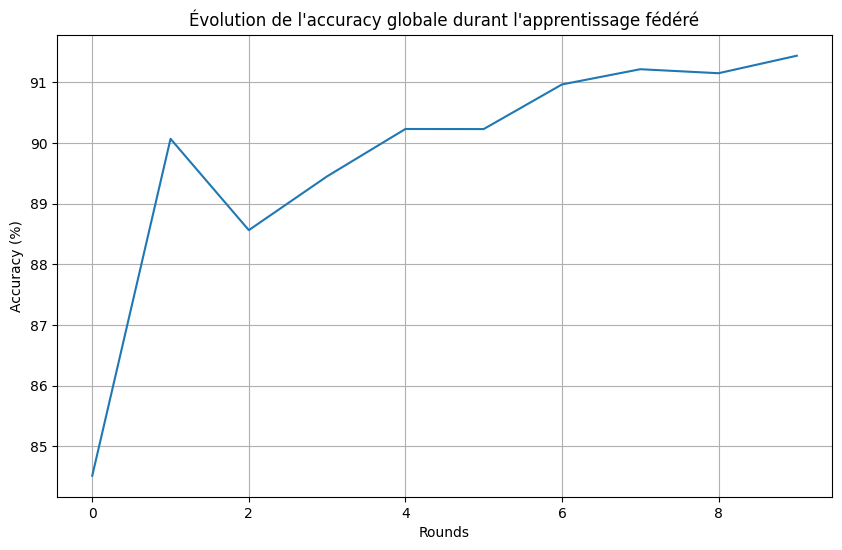

In [ ]:
# Préparation des données pour chaque client
client_datasets = []

for client_df in client_data:
    # Sélection des caractéristiques et de la cible
    X = client_df.drop(['Mortality', 'Mortality_48h', 'Mortality_30d', 'icustay_id_x', 'charttime', 'subject_id', 'hadm_id', 'icustay_id_y'], axis=1).values
    y = client_df['Mortality'].values

    # Division en ensembles d'entraînement et de test (80% / 20%)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    client_datasets.append(((X_train, y_train), (X_test, y_test)))

# Initialisation du modèle global
# Récupération du nombre réel de caractéristiques à partir des données
if len(client_datasets) > 0 and len(client_datasets[0]) > 0:
    input_dim = client_datasets[0][0][0].shape[1]  # Nombre de caractéristiques
    hidden_dim = 64  # Plus grand modèle pour des données complexes
    output_dim = 1   # Classification binaire (survie/décès)

# Création du modèle global
global_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
print(f"Modèle global initialisé avec {input_dim} caractéristiques d'entrée, {hidden_dim} neurones cachés")

# Initialisation des clients fédérés
federated_clients = []
for i, dataset in enumerate(client_datasets):
    client = FederatedClient(
        client_id=f"Client_{i+1}",
        train_data=dataset[0],
        test_data=dataset[1],
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout_prob=0.3,
        lr=0.001
    )
    federated_clients.append(client)
    print(f"Client_{i+1} initialisé avec {len(dataset[0][0])} échantillons d'entraînement et {len(dataset[1][0])} échantillons de test")

# Initialisation du serveur fédéré
federated_server = FederatedServer(global_model, federated_clients)
print("Serveur fédéré initialisé")

# Lancement de l'apprentissage fédéré (5 rounds)
print("\nDémarrage de l'apprentissage fédéré...")
# Utilisation de l'early stopping
train_accuracies, test_accuracies, train_losses, test_losses, history = run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3)

# Visualiser l'évolution de l'accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title('Évolution de l\'accuracy globale durant l\'apprentissage fédéré')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()



# Évaluation de l'accuracy dans l'apprentissage fédéré
évaluation de la précision (accuracy) du modèle fédéré. Dans l'apprentissage fédéré, l'évaluation de la précision est particulière car elle doit agréger les performances sur plusieurs clients sans partager les données brutes. Nous allons:

- Créer une fonction d'évaluation globale qui agrège les métriques des clients

- Évaluer le modèle fédéré sur les données de test de tous les clients

- Comparer les performances du modèle fédéré avec un modèle centralisé (pour référence)

- Visualiser les résultats d'accuracy par client et globalement

=== Évaluation du modèle fédéré ===
Client_1: Accuracy = 0.9052 (sur 306 échantillons)
Client_2: Accuracy = 0.8571 (sur 7 échantillons)
Client_3: Accuracy = 0.9091 (sur 22 échantillons)
Client_4: Accuracy = 0.8951 (sur 572 échantillons)
Client_5: Accuracy = 0.9194 (sur 868 échantillons)
Client_6: Accuracy = 0.9091 (sur 11 échantillons)
Client_7: Accuracy = 0.9206 (sur 2343 échantillons)
Client_8: Accuracy = 0.9218 (sur 614 échantillons)
Client_9: Accuracy = 1.0000 (sur 1 échantillons)
Client_10: Accuracy = 0.9185 (sur 920 échantillons)

=== Résultats globaux ===
Accuracy moyenne pondérée: 0.9167
Accuracy globale: 0.9093
Precision: 0.7907
Recall: 0.7478
F1 Score: 0.7687

=== Entraînement d'un modèle centralisé (référence) ===
Epoch 2/10, Loss: 10.0123
Epoch 4/10, Loss: 3.4943
Epoch 6/10, Loss: 0.9204
Epoch 8/10, Loss: 0.4230
Epoch 10/10, Loss: 0.3077

=== Résultats du modèle centralisé ===
Accuracy: 0.8965
Precision: 0.8124
Recall: 0.6331
F1 Score: 0.7116


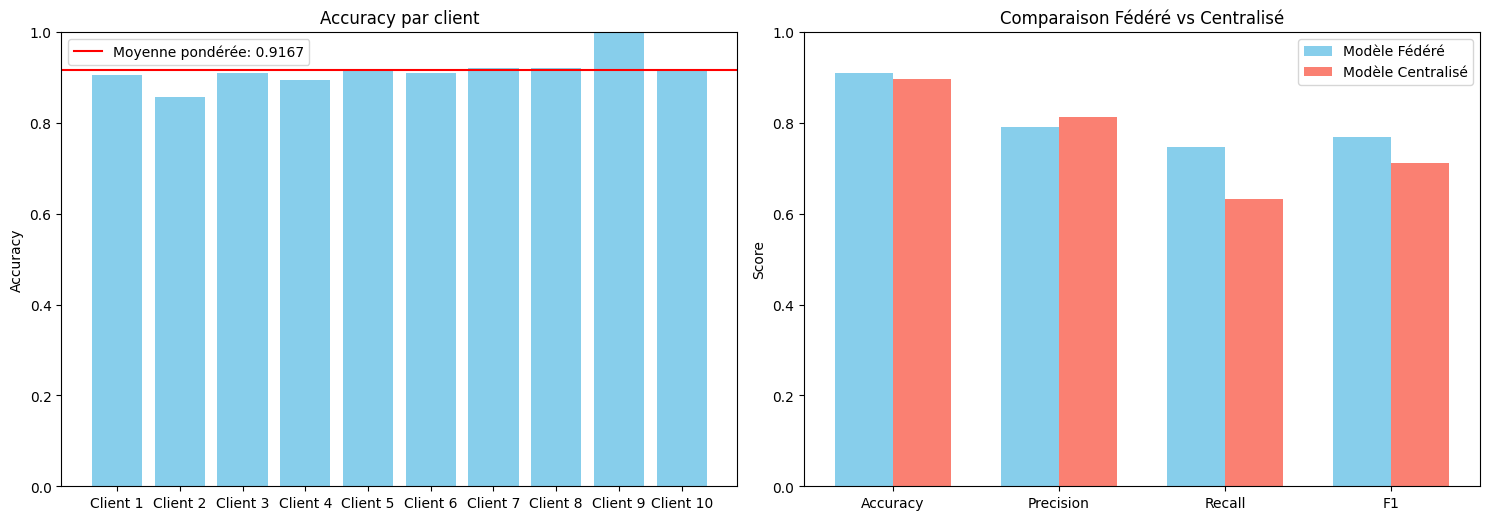

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Ajoutons d'abord une méthode à la classe FederatedClient pour accéder aux données brutes si nécessaire
def get_raw_data(self):
    """
    Récupérer les données brutes à partir du DataLoader pour les évaluations externes.

    Returns:
        tuple: (X_test, y_test) contenant les caractéristiques et étiquettes de test
    """
    X_test_list = []
    y_test_list = []

    # Parcourir le DataLoader pour extraire toutes les données
    for features, labels in self.test_loader:
        X_test_list.append(features.numpy())
        y_test_list.append(labels.numpy())

    # Concaténer tous les batches
    X_test = np.vstack(X_test_list)
    y_test = np.vstack(y_test_list).reshape(-1)

    return X_test, y_test

# Ajouter dynamiquement la méthode à la classe
FederatedClient.get_raw_data = get_raw_data

# Fonction pour évaluer le modèle fédéré globalement
def evaluate_federated_model():
    print("=== Évaluation du modèle fédéré ===")

    # Résultats par client
    client_accuracies = []
    client_sizes = []

    # Autres métriques globales
    all_y_true = []
    all_y_pred = []

    # Évaluation par client
    for client in federated_clients:
        # Utiliser la méthode evaluate() existante qui retourne déjà l'accuracy
        local_accuracy = client.evaluate() / 100  # Convertir pourcentage en fraction

        # Obtenir les données brutes pour les métriques détaillées
        X_test, y_test = client.get_raw_data()
        client_sizes.append(len(X_test))

        # Appliquer le modèle global aux données pour obtenir les prédictions
        client.model.load_state_dict(global_model.state_dict())  # Assurer que le client utilise le modèle global
        client.model.eval()

        with torch.no_grad():
            outputs = client.model(torch.tensor(X_test, dtype=torch.float32))
            y_pred = (torch.sigmoid(outputs) > 0.5).float().numpy().reshape(-1)

        # Stocker l'accuracy locale
        client_accuracies.append(local_accuracy)

        # Collecter pour les métriques globales
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        print(f"{client.client_id}: Accuracy = {local_accuracy:.4f} (sur {len(X_test)} échantillons)")

    # Calcul de la moyenne pondérée (par taille d'échantillon)
    weighted_avg_accuracy = sum(acc * size for acc, size in zip(client_accuracies, client_sizes)) / sum(client_sizes)

    # Métriques globales
    global_accuracy = accuracy_score(all_y_true, all_y_pred)
    global_precision = precision_score(all_y_true, all_y_pred, zero_division=0)
    global_recall = recall_score(all_y_true, all_y_pred, zero_division=0)
    global_f1 = f1_score(all_y_true, all_y_pred, zero_division=0)

    print("\n=== Résultats globaux ===")
    print(f"Accuracy moyenne pondérée: {weighted_avg_accuracy:.4f}")
    print(f"Accuracy globale: {global_accuracy:.4f}")
    print(f"Precision: {global_precision:.4f}")
    print(f"Recall: {global_recall:.4f}")
    print(f"F1 Score: {global_f1:.4f}")

    # Retourner les métriques pour comparaison ou visualisation
    return {
        'client_accuracies': client_accuracies,
        'weighted_avg_accuracy': weighted_avg_accuracy,
        'global_accuracy': global_accuracy,
        'global_precision': global_precision,
        'global_recall': global_recall,
        'global_f1': global_f1
    }

# Entrainer un modèle centralisé pour comparaison
def train_centralized_model():
    print("\n=== Entraînement d'un modèle centralisé (référence) ===")

    # Combiner les données de tous les clients
    X_train_all = []
    y_train_all = []
    X_test_all = []
    y_test_all = []

    for client in federated_clients:
        # Extraire les données brutes de chaque client
        for batch_x, batch_y in client.train_loader:
            X_train_all.append(batch_x.numpy())
            y_train_all.append(batch_y.numpy())

        X_test, y_test = client.get_raw_data()
        X_test_all.append(X_test)
        y_test_all.append(y_test)

    X_train_all = np.vstack(X_train_all)
    y_train_all = np.vstack(y_train_all).reshape(-1, 1)
    X_test_all = np.vstack(X_test_all)
    y_test_all = np.concatenate(y_test_all)

    # Créer et entraîner un modèle centralisé
    centralized_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(centralized_model.parameters(), lr=0.001)

    # Convertir les données en tenseurs
    X_train_tensor = torch.FloatTensor(X_train_all)
    y_train_tensor = torch.FloatTensor(y_train_all)

    # Créer un DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Entraînement
    epochs = 10

    for epoch in range(epochs):
        centralized_model.train()
        epoch_loss = 0
        num_batches = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = centralized_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f}")

    # Évaluer le modèle centralisé
    X_test_tensor = torch.FloatTensor(X_test_all)
    y_test_tensor = torch.FloatTensor(y_test_all).reshape(-1, 1)

    centralized_model.eval()
    with torch.no_grad():
        y_pred_proba = centralized_model(X_test_tensor)
        y_pred = (torch.sigmoid(y_pred_proba) > 0.5).float().numpy().reshape(-1)

    centralized_accuracy = accuracy_score(y_test_all, y_pred)
    centralized_precision = precision_score(y_test_all, y_pred, zero_division=0)
    centralized_recall = recall_score(y_test_all, y_pred, zero_division=0)
    centralized_f1 = f1_score(y_test_all, y_pred, zero_division=0)

    print("\n=== Résultats du modèle centralisé ===")
    print(f"Accuracy: {centralized_accuracy:.4f}")
    print(f"Precision: {centralized_precision:.4f}")
    print(f"Recall: {centralized_recall:.4f}")
    print(f"F1 Score: {centralized_f1:.4f}")

    return {
        'accuracy': centralized_accuracy,
        'precision': centralized_precision,
        'recall': centralized_recall,
        'f1': centralized_f1
    }

# Visualisation comparative des résultats
def visualize_results(federated_metrics, centralized_metrics):
    plt.figure(figsize=(15, 10))

    # Graphique 1: Accuracy par client
    plt.subplot(2, 2, 1)
    client_ids = [f"Client {i+1}" for i in range(len(federated_metrics['client_accuracies']))]
    plt.bar(client_ids, federated_metrics['client_accuracies'], color='skyblue')
    plt.axhline(y=federated_metrics['weighted_avg_accuracy'], color='r', linestyle='-', label=f"Moyenne pondérée: {federated_metrics['weighted_avg_accuracy']:.4f}")
    plt.title('Accuracy par client')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    # Graphique 2: Comparaison Fédéré vs Centralisé
    plt.subplot(2, 2, 2)
    comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    federated_values = [federated_metrics['global_accuracy'], federated_metrics['global_precision'],
                         federated_metrics['global_recall'], federated_metrics['global_f1']]
    centralized_values = [centralized_metrics['accuracy'], centralized_metrics['precision'],
                          centralized_metrics['recall'], centralized_metrics['f1']]

    x = np.arange(len(comparison_metrics))
    width = 0.35

    plt.bar(x - width/2, federated_values, width, label='Modèle Fédéré', color='skyblue')
    plt.bar(x + width/2, centralized_values, width, label='Modèle Centralisé', color='salmon')
    plt.title('Comparaison Fédéré vs Centralisé')
    plt.xticks(x, comparison_metrics)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.savefig('federated_vs_centralized_performance.png')
    plt.show()

# Exécuter l'évaluation
federated_metrics = evaluate_federated_model()
centralized_metrics = train_centralized_model()
visualize_results(federated_metrics, centralized_metrics)
